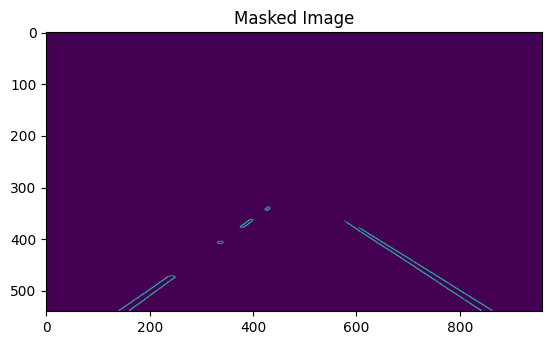

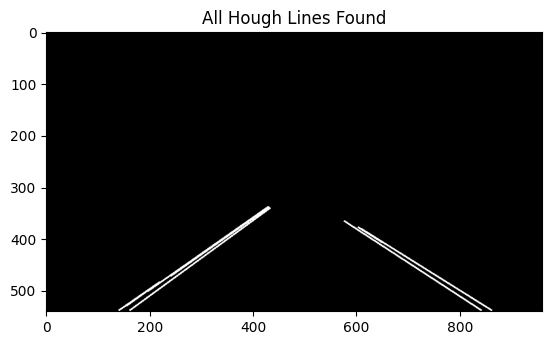

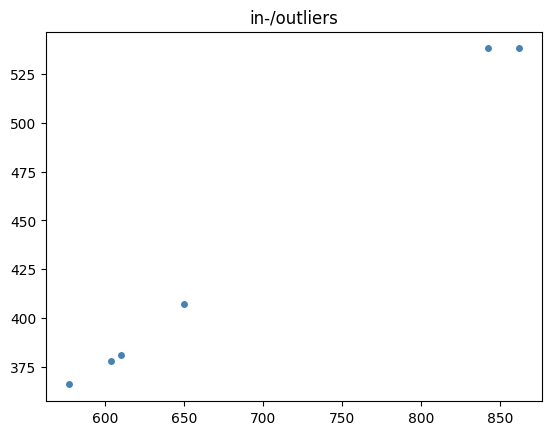

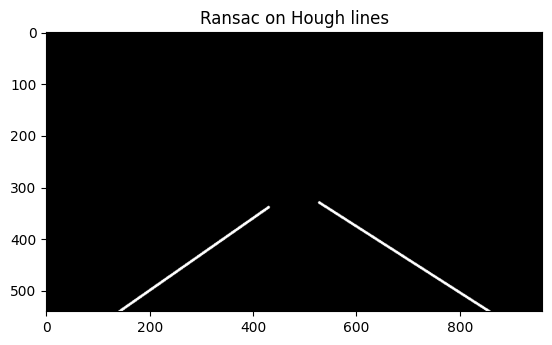

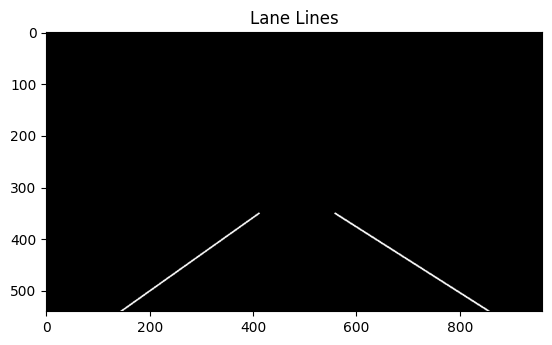

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from sklearn import linear_model

# Get all images
test_images = [mpimg.imread('test_video/videoFrames/' + i) for i in os.listdir('test_video/videoFrames/')]
test_image_names = ['test_video/videoFrames/'+i for i in os.listdir('test_video/videoFrames/')]


#----------------GET IMAGE-----------------
im = test_images[0]
imshape = im.shape
# plt.figure(1)
# plt.imshow(im)
# plt.title(test_image_names[0])

# -------------GREYSCALE IMAGE---------------
# Grayscale one color channel
# specify cmap = 'gray' in plt.imshow
grayIm = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# plt.figure(2)
# plt.imshow(grayIm,cmap='gray')
# plt.title('Greyscaled image')


#------------GAUSSIAN SMOOTHING-----------------
# Use low pass filter to remove noise. Will remove high freq stuff like noise and edges
# kernel_size specifies width/height of kernel, should be positive and odd
# Also specify stand dev in X and Y direction, give zero to calculate from kernel size
# Can also use average, median, and bilarteral blurring techniques
kernel_size = 9; # bigger kernel = more smoothing
smoothedIm = cv2.GaussianBlur(grayIm, (kernel_size, kernel_size), 0)
# plt.figure(3)
# plt.imshow(smoothedIm,cmap='gray')
# plt.title('Smoothed image')


#-------------EDGE DETECTION---------------------
# finds gradient in x,y direction, gradient direction is perpendicular to edges
# checks pixels in gradient directions to see if they are local maximums, meaning on an edge
# hysteresis thresholding has min and max value, edges with gradient intensity big enough are edges
# edges that lie in bewteen are check to see if they connect to edges with intensity greater than max value, then it is considered edge
# also assumes edges are long lines (not small pixels regions)
minVal = 60
maxVal = 150
edgesIm = cv2.Canny(smoothedIm, minVal, maxVal)
# plt.figure(4)
# implot = plt.imshow(edgesIm,cmap='gray')

#plt.scatter([0],[imshape[0]])
#plt.scatter([465],[320])
#plt.scatter([475],[320])
#plt.scatter([imshape[1]],[imshape[0]])

# plt.title('Edge Detection')


#-------------------------CREATE MASK--------------------------------
# Create mask to only keep area defined by four coners
# Black out every area outside area
vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)

# defining a blank mask to start with, 0s with same shape of edgesIm
mask = np.zeros_like(edgesIm)   
          
# fill pixels inside the polygon defined by vertices"with the fill color  
color = 255
cv2.fillPoly(mask, vertices, color)

# # show mask
# plt.figure(5)
# plt.imshow(mask,cmap='gray')
# plt.title('Mask')
    
#----------------------APPLY MASK TO IMAGE-------------------------------
# create image only where mask and edge Detection image are the same
maskedIm = cv2.bitwise_and(edgesIm, mask)
    
# # Plot output of mask
plt.figure(6)
plt.imshow(maskedIm)
plt.title('Masked Image')

# Plot masked edges image
maskedIm3Channel = cv2.cvtColor(maskedIm, cv2.COLOR_GRAY2BGR)


def draw_lines(img, lines, color_left=[255, 255, 255], color_right=[255, 255, 255], thickness=4):
    
    plane = np.zeros_like(img)
    imshape = plane.shape
    
    slope_min = 0.1
    slope_max = 20
    x_right = []
    y_right = []
    
    x_left = []
    y_left = []

    if lines is None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            if m < -slope_min and m > -slope_max: #left
                if x1 > imshape[1]*0.5 or x2 > imshape[1]*0.5:
                    continue
                else:
                    x_left.append([x1])
                    x_left.append([x2])
                    y_left.append(y1)
                    y_left.append(y2)
            elif m > slope_min and m < slope_max: #right
                if x1 < imshape[1]*0.5 or x2 < imshape[1]*0.5:
                    continue
                else:
                    x_right.append([x1])
                    x_right.append([x2])
                    y_right.append(y1)
                    y_right.append(y2)
   
    x_right = np.array(x_right)
    y_right = np.array(y_right)
    model_ransac_right = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac_right.fit(x_right, y_right)
    line_x_right = np.arange(imshape[1]*0.55, imshape[1])
    line_y_right = model_ransac_right.predict(line_x_right[:, np.newaxis])
    cv2.line(plane, (int(line_x_right[0]), int(line_y_right[0])), (int(line_x_right[len(line_x_right)-1]), int(line_y_right[len(line_y_right)-1])), color_right, thickness)

    # # Check in-/outlier dataset in rightside data 
    # inlier_mask = model_ransac_right.inlier_mask_
    # outlier_mask = np.logical_not(inlier_mask)
    # plt.figure(12)
    # plt.scatter(x_right[inlier_mask], y_right[inlier_mask],
    #         c='steelblue', edgecolor='white',
    #         marker='o', label='Inliers')
    # plt.scatter(x_right[outlier_mask], y[outlier_mask],
    #          c='limegreen', edgecolor='white',
    #          marker='s', label='Outliers')
    # plt.title('in-/outliers')

    x_left = np.array(x_left)
    y_left = np.array(y_left)
    model_ransac_left = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac_left.fit(x_left, y_left)
    line_x_left = np.arange(0, imshape[1]*0.45)
    line_y_left = model_ransac_left.predict(line_x_left[:, np.newaxis])
    cv2.line(plane, (int(line_x_left[0]), int(line_y_left[0])), (int(line_x_left[len(line_x_left)-1]), int(line_y_left[len(line_y_left)-1])), color_left, thickness)
    
    return plane

#-----------------------HOUGH LINES------------------------------------
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 45     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(maskedIm, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)



# Check if we got more than 1 line
if lines is not None and len(lines) > 2:
    # Draw all lines onto image
    allLines = np.zeros_like(maskedIm)
    for i in range(len(lines)):
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(allLines,(x1,y1),(x2,y2),(255,255,0),2) # plot line


    # Plot all lines found
    plt.figure(7)
    plt.imshow(allLines,cmap='gray')
    plt.title('All Hough Lines Found')

    ransac_img = draw_lines(allLines, lines)
    plt.figure(11)
    plt.imshow(ransac_img, cmap='gray')
    plt.title('Ransac on Hough lines')


    #-----------------------Separate Lines Intro Positive/Negative Slope--------------------------
    # Separate line segments by their slope to decide left line vs. the right line
    slopePositiveLines = [] # x1 y1 x2 y2 slope
    slopeNegativeLines = []
    yValues = []


    # Loop through all lines
    addedPos = False
    addedNeg = False
    for currentLine in lines:   
        # Get points of current Line
        for x1,y1,x2,y2 in currentLine:
            lineLength = ((x2-x1)**2 + (y2-y1)**2)**.5 # get line length
            if lineLength > 30: # if line is long enough
                if x2 != x1: # dont divide by zero
                    slope = (y2-y1)/(x2-x1) # get slope line
                    if slope > 0: 
                        # Check angle of line w/ xaxis. dont want vertical/horizontal lines
                        tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                        ang = np.arctan(tanTheta)*180/np.pi
                        if abs(ang) < 85 and abs(ang) > 20:
                            slopeNegativeLines.append([x1,y1,x2,y2,-slope]) # add positive slope line
                            yValues.append(y1)
                            yValues.append(y2)
                            addedPos = True # note that we added a positive slope line
                    if slope < 0:
                        # Check angle of line w/ xaxis. dont want vertical/horizontal lines
                        tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                        ang = np.arctan(tanTheta)*180/np.pi
                        if abs(ang) < 85 and abs(ang) > 20:
                            slopePositiveLines.append([x1,y1,x2,y2,-slope]) # add negative slope line
                            yValues.append(y1)
                            yValues.append(y2)
                            addedNeg = True # note that we added a negative slope line
           
            
    # If we didn't get any positive lines, go though again and just add any positive slope lines         
    if not addedPos:
        for currentLine in lines:
            for x1,y1,x2,y2 in currentLine:
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    # Check angle of line w/ xaxis. dont want vertical/horizontal lines
                    tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                    ang = np.arctan(tanTheta)*180/np.pi
                    if abs(ang) < 80 and abs(ang) > 15:
                        slopeNegativeLines.append([x1,y1,x2,y2,-slope])
                        yValues.append(y1)
                        yValues.append(y2)
    
    # If we didn't get any negative lines, go through again and just add any negative slope lines
    if not addedNeg:
        for currentLine in lines:
            for x1,y1,x2,y2 in currentLine:
                slope = (y2-y1)/(x2-x1)
                if slope < 0:
                    # Check angle of line w/ xaxis. dont want vertical/horizontal lines
                    tanTheta = np.tan((abs(y2-y1))/(abs(x2-x1))) # tan(theta) value
                    ang = np.arctan(tanTheta)*180/np.pi
                    if abs(ang) < 85 and abs(ang) > 15:
                        slopePositiveLines.append([x1,y1,x2,y2,-slope])           
                        yValues.append(y1)
                        yValues.append(y2)
                   
    
    if not addedPos or not addedNeg:
        print('Not enough lines found')
    
    
    #------------------------Get Positive/Negative Slope Averages-----------------------------------
    # Average position of lines and extrapolate to the top and bottom of the lane.
    positiveSlopes = np.asarray(slopePositiveLines)[:,4]
    posSlopeMedian = np.median(positiveSlopes)
    posSlopeStdDev = np.std(positiveSlopes)
    posSlopesGood = []
    for slope in positiveSlopes:
       # if abs(slope-posSlopeMedian) < .9:
       if abs(slope-posSlopeMedian) < posSlopeMedian*.2:
            posSlopesGood.append(slope)
    posSlopeMean = np.mean(np.asarray(posSlopesGood))
            
    
    negativeSlopes = np.asarray(slopeNegativeLines)[:,4]
    negSlopeMedian = np.median(negativeSlopes)
    negSlopeStdDev = np.std(negativeSlopes)
    negSlopesGood = []
    for slope in negativeSlopes:
        if abs(slope-negSlopeMedian) < .9:
            negSlopesGood.append(slope)
    negSlopeMean = np.mean(np.asarray(negSlopesGood))
        
    #--------------------------Get Average x Coord When y Coord Of Line = 0----------------------------
    # Positive Lines
    xInterceptPos = []
    for line in slopePositiveLines:
            x1 = line[0]
            y1 = im.shape[0]-line[1] # y axis is flipped
            slope = line[4]
            yIntercept = y1-slope*x1
            xIntercept = -yIntercept/slope # find x intercept based off y = mx+b
            if xIntercept == xIntercept: # checks for nan
                xInterceptPos.append(xIntercept) # add x intercept
            
    xIntPosMed = np.median(xInterceptPos) # get median 
    xIntPosGood = [] # if not near median we get rid of that x point
    for line in slopePositiveLines:
            x1 = line[0]
            y1 = im.shape[0]-line[1]
            slope = line[4]
            yIntercept = y1-slope*x1
            xIntercept = -yIntercept/slope
            if abs(xIntercept-xIntPosMed) < .35*xIntPosMed: # check if near median
                xIntPosGood.append(xIntercept)
                    
    xInterceptPosMean = np.mean(np.asarray(xIntPosGood)) # average of good x intercepts for positive line
    
    # Negative Lines 
    xInterceptNeg = []
    for line in slopeNegativeLines:
        x1 = line[0]
        y1 = im.shape[0]-line[1]
        slope = line[4]
        yIntercept = y1-slope*x1
        xIntercept = -yIntercept/slope
        if xIntercept == xIntercept: # check for nan
                xInterceptNeg.append(xIntercept)
                
    xIntNegMed = np.median(xInterceptNeg)
    xIntNegGood = []
    for line in slopeNegativeLines:
        x1 = line[0]
        y1 = im.shape[0]-line[1]
        slope = line[4]
        yIntercept = y1-slope*x1
        xIntercept = -yIntercept/slope
        if abs(xIntercept-xIntNegMed)< .35*xIntNegMed: 
                xIntNegGood.append(xIntercept)
                
    xInterceptNegMean = np.mean(np.asarray(xIntNegGood))


# ----------------------PLOT LANE LINES------------------------------
# Need end points of line to draw in. Have x1,y1 (xIntercept,im.shape[1]) where
# im.shape[1] is the bottom of the image. take y2 as some num (min/max y in the good lines?)
# then find corresponding x

# make new black image
laneLines = np.zeros_like(edgesIm)   
colorLines = im.copy()

# Positive Slope Line
slope = posSlopeMean
x1 = xInterceptPosMean
y1 = 0
y2 = imshape[0] - (imshape[0]-imshape[0]*.35)
x2 = (y2-y1)/slope + x1

# Plot positive slope line
x1 = int(round(x1))
x2 = int(round(x2))
y1 = int(round(y1))
y2 = int(round(y2))
cv2.line(laneLines,(x1,im.shape[0]-y1),(x2,imshape[0]-y2),(255,255,0),2) # plot line
cv2.line(colorLines,(x1,im.shape[0]-y1),(x2,imshape[0]-y2),(0,255,0),4) # plot line on color image

# Negative Slope Line
slope = negSlopeMean
x1N = xInterceptNegMean
y1N = 0
x2N = (y2-y1N)/slope + x1N

# Plot negative Slope Line
x1N = int(round(x1N))
x2N = int(round(x2N))
y1N = int(round(y1N))
cv2.line(laneLines,(x1N,imshape[0]-y1N),(x2N,imshape[0]-y2),(255,255,0),2)
cv2.line(colorLines,(x1N,im.shape[0]-y1N),(x2N,imshape[0]-y2),(0,255,0),4) # plot line on color iamge

# Plot lane lines
plt.figure(8)
plt.imshow(laneLines,cmap='gray')
plt.title('Lane Lines')

# # Plot lane lines on original image
# plt.figure(9)
# plt.imshow(colorLines)
# plt.title('Lane Lines Color Image')





#-------------------------------------Blend Image-----------------------------------------
laneFill = im.copy()
vertices = np.array([[(x1,im.shape[0]-y1),(x2,im.shape[0]-y2),  (x2N,imshape[0]-y2),
                                      (x1N,imshape[0]-y1N)]], dtype=np.int32)
color = [241,255,1]
cv2.fillPoly(laneFill, vertices, color)
opacity = .25
blendedIm =cv2.addWeighted(laneFill,opacity,im,1-opacity,0,im)
cv2.line(blendedIm,(x1,im.shape[0]-y1),(x2,imshape[0]-y2),(0,255,0),4) # plot line on color image
cv2.line(blendedIm,(x1N,im.shape[0]-y1N),(x2N,imshape[0]-y2),(0,255,0),4) # plot line on color image
b,g,r = cv2.split(blendedIm) # get bgr channels
outputIm = cv2.merge((r,g,b)) # make rgb

# # Plot final output
# plt.figure(10)
# plt.imshow(blendedIm)
# plt.title('Final Output')